In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch 
import matplotlib.pylab as plt

import os


In [2]:
data  = pd.read_csv("/kaggle/input/cats-in-the-wild-image-classification/WILDCATS.CSV")
data.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/AFRICAN LEOPARD/001.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
1,0,train/AFRICAN LEOPARD/002.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
2,0,train/AFRICAN LEOPARD/003.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
3,0,train/AFRICAN LEOPARD/004.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
4,0,train/AFRICAN LEOPARD/005.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus


In [3]:
train_rows = data.loc[data['data set'] == 'train']
test_rows  = data.loc[data['data set'] == 'test']
valid_rows = data.loc[data['data set'] == 'valid']

print("Size of : Train:{}, Test:{}, Valid:{}".format(len(train_rows),len(test_rows),len(valid_rows)))

Size of : Train:2339, Test:50, Valid:50


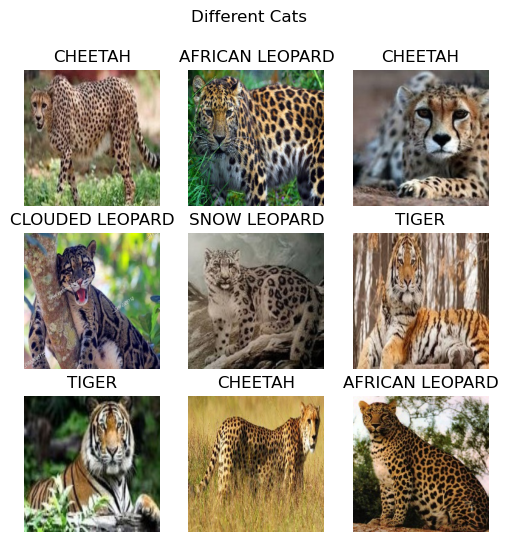

In [4]:

home_path = "/kaggle/input/cats-in-the-wild-image-classification/"
cols = 3
rows = 3
figure = plt.figure(figsize = (6,6))


for i in range(1,cols*rows+1):
    sample_idx = torch.randint(len(train_rows),size= (1,)).item()
    figure.add_subplot(rows,cols,i)
    image = plt.imread(home_path +train_rows['filepaths'][sample_idx])
    plt.imshow(image)
    plt.title(train_rows['labels'][sample_idx])
    plt.axis("off")

plt.suptitle("Different Cats")
plt.show()
    
    
    

In [5]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class bigCatsDataset():
    
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
#         print(idx)
#         print(list(self.data['filepaths'])[])
        image_path = home_path + self.data['filepaths'].iloc[idx]
        image = transforms.functional.rotate(self.transform(plt.imread(image_path)), 90)
        output = self.data['class id'].iloc[idx]
        return image,output


In [17]:
from torch.utils.data import DataLoader

train_data = DataLoader(bigCatsDataset(train_rows),batch_size  = 32,shuffle = True)
test_data = DataLoader(bigCatsDataset(test_rows),batch_size  = 1,shuffle = False)
valid_data = DataLoader(bigCatsDataset(valid_rows),batch_size  = 1,shuffle = False)


In [7]:
from torchvision import models
# Let's now setup the model
# We will use the pretrained Resnet100


class Model(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        
        # Load the ResNet model
        resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
 
        # Reconstruct the model without the last layer
        self.net = torch.nn.Sequential(*list(resnet.children())[:-1])
        # Build fully connected layers to handle predictions
        self.fcs = torch.nn.Sequential(
            torch.nn.Linear(2048, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, num_classes)
        )
        
    def forward(self, x):
        # Pass the input through the ResNext model
        x = self.net(x)
        # Flatten the output of ResNet
        x = x.view(x.shape[0], -1)
        # Send to fully connected layer
        return self.fcs(x)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
m = Model().to(device)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [14]:
import torch.nn.functional as F
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
opt = optim.SGD(m.parameters(), lr=0.01, momentum=0.5, weight_decay=0.0)
EPOCHS = 10

for i in range(EPOCHS):
    correct = 0
    total = 0 
    for data, target in train_data:

        
        data, target = data.to(device), target.to(device)
        
        
        
        opt.zero_grad()
        
        output = m(data)
        loss = criterion(output, target)
        
        loss.backward()
        opt.step()
        
        _, predicted = torch.max(output, axis=1)
        
        correct += (predicted == target).sum().item()
        total += target.size(0)
        
        
    print("Loss at Epoch {} : {} with Training Accuracy {}".format(i,loss,(correct/total)*100))
    

Loss at Epoch 0 : 0.6339129209518433 with Training Accuracy 83.96750748182984
Loss at Epoch 1 : 0.29868215322494507 with Training Accuracy 87.51603249251816
Loss at Epoch 2 : 0.0019676624797284603 with Training Accuracy 91.91962377084224
Loss at Epoch 3 : 0.002075259340927005 with Training Accuracy 97.30654125694741
Loss at Epoch 4 : 9.126978693529963e-05 with Training Accuracy 98.84566053869175
Loss at Epoch 5 : 0.00028379663126543164 with Training Accuracy 99.82898674647285
Loss at Epoch 6 : 0.0011836531339213252 with Training Accuracy 99.82898674647285
Loss at Epoch 7 : 0.0005041551776230335 with Training Accuracy 100.0
Loss at Epoch 8 : 6.333467899821699e-05 with Training Accuracy 100.0
Loss at Epoch 9 : 0.00042687333188951015 with Training Accuracy 100.0


In [15]:
m.eval()

def get_label(val):
  
    return train_rows.loc[train_rows['class id'] == val.item()]['labels'].iloc[0]
    
c = 0
t = 0
for data, target in test_data:
    out = m(data.to(device))
    out = out.data.max(1)[1]
    print("Actual Output: {}, Predicted :{}".format(get_label(target),get_label(out)))
    if(get_label(target)==get_label(out)):
        c = c+1
    t = t+1
        
        
print("Testing Accuracy = " , c/t)

Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CLOUDED LEOPARD, Predicted :CLOUDED LEOPARD
Actual Output: CLOUDED LEOPARD, Predicted :CLOUDED LEOPARD
Actual Output: CLOUDED LEOPARD, Predicted :CLOUDED LEOPARD
Actual Output: CLOUDED LEOPARD, Predicted :CLOUDED LEOPARD
Actual Output: CLOUDED LEOPARD, Predict

In [18]:
c = 0
t = 0
for data, target in valid_data:
    out = m(data.to(device))
    out = out.data.max(1)[1]
    print("Actual Output: {}, Predicted :{}".format(get_label(target),get_label(out)))
    if(get_label(target)==get_label(out)):
        c = c+1
    t = t+1
        
        
print("Testing Accuracy = " , c/t)

Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: AFRICAN LEOPARD, Predicted :AFRICAN LEOPARD
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CARACAL, Predicted :CARACAL
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CHEETAH, Predicted :CHEETAH
Actual Output: CLOUDED LEOPARD, Predicted :CLOUDED LEOPARD
Actual Output: CLOUDED LEOPARD, Predicted :CLOUDED LEOPARD
Actual Output: CLOUDED LEOPARD, Predicted :CLOUDED LEOPARD
Actual Output: CLOUDED LEOPARD, Predicted :CLOUDED LEOPARD
Actual Output: CLOUDED LEOPARD, Predict